Face Recognition

Tina Rezvanian

# 3.	What if we want to add another person to the existing database for face recognition, or if the person in the image is not in our database?

In the previous sections, we improved on the learning of existing pretrained models of VGG16 and ResNet50, using feature extraction, transfer learning, and finetuning with data augmentation and regularization. Both aforementioned models were trained on VGGFACE2 data. So far we have compared the performance of these two architectures in the repurposed models. The drawback of these models is that, if we are to add another person to our data base, or we want to classify those not in our database as well, then we need to retrain models to include the additionally added classes in the final output layer.


In this section, this project explores how deep learning models can be exploited such that we can add new members to our data base, or identify those not in our database. Since we already compared two architectures trained on same dataset, I wasn’t to compare a model trained on a different dataset in this section. However, any of the developed models could be used as well.


FaceNet model developed by  Google  and  was  trained  on  MS-Celeb-1M  dataset (here) and expects input images to be color, to have their pixel values standardized across all three channels, and to have a square shape of 160×160 pixels.  

- Download  the pretrained model from here:https://github.com/nyoki-mtl/keras-facenet this model works with  the following enviroment:python3.6.2/tensorflow: 1.3.0/keras: 2.1.2 I have  downloaded model to  the ‘facenet_path’ directory.

1.	Create a people directory including one image per subject as the database for FaceNet model
2.	Capture embeddings of faces in database using FaceNet model
3.	Capture embeddings of candidate faces for the 11 subjects 
4.	Compare the embeddings of candidate faces with database embedings using a distance function


In [1]:
import os
import pickle
import numpy as np
import cv2
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from PIL import Image
from numpy import asarray
from scipy.spatial import distance
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import Normalizer

Using TensorFlow backend.


In [2]:
facenet_path = 'keras-facenet/model/facenet_keras.h5'
people_dir = 'keras-facenet/data/database'
test_dir = 'keras-facenet/data/test'
required_size = (160,160)

In [3]:
# Create functions for shrtenning the codes

In [4]:
# get embeddings of peaple's face in my dataset
def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

def find_embedding(facenet_model, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = facenet_model.predict(np.expand_dims(face, axis=0))[0]
    return encode

l2_normalizer = Normalizer('l2')

def extract_face(img_path, required_size=required_size):
    # load image from file
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # create detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(img_rgb)
    # extract the bounding box associated to larger area
    bigger_face = max(results, key=lambda b: b['box'][2] * b['box'][3])
    x1, y1, width, height = bigger_face['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = img_rgb[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

def get_points(img_rgb, box):
#     extract the points in a image and its associated face
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img_rgb[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

#  Prepare our database from people image: 

The output of the FaceNet model is a vector of size (128,). This vector represents the embedding of a face. I will create a database called ‘embedding_dict’, that will include the embeddings associated to image in the database. If we were to use our developed models in section 2, we would remove the classification layer from the model, and get the prediction of size of the last dense layer. In feature extraction, this is already been done except that the predictions are from the convolutional base. Here the predictions would have been from the last dense layer.!

In [5]:
face_detector = MTCNN()
facenet_model = load_model(facenet_path)

embedding_dict = dict()

for celeb  in os.listdir(people_dir):
    if not celeb.startswith('.'):
        person_dir = os.path.join(people_dir, celeb)
        embedding_list = []
        for img_name in os.listdir(person_dir):
            if not img_name.startswith('.'):
                fullimagepath = os.path.join(person_dir, img_name)
                face = extract_face(fullimagepath)
                face = normalize(face)            
                face = cv2.resize(face, required_size)
                face = expand_dims(face, axis=0)
                embedding = facenet_model.predict(face)[0]
                embedding_list.append(embedding)

        embedding = np.sum(embedding_list, axis=0)
        embedding = l2_normalizer.transform(np.expand_dims(embedding, axis=0))[0]
        embedding_dict[celeb] = embedding

for key in embedding_dict.keys():
    print(key)
        

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Teri_Hatcher
Geena_Davis
Neve_Campbell
Kevin_Bacon
Patricia_Arquette
Steve_Buscemi
Kim_Basinger
David_Duchovny
Helen_Hunt
Colin_Firth
Jeff_Goldblum


In [6]:
embedding.shape

(128,)

# Face Recognition:
    - to identify if the candidate picture in the test_dir belongs to someone in our database, now it is sufficient to compare the embeddings that we saved in our 'embedding_dict' to the embedding of the candidate faces in the test_dir

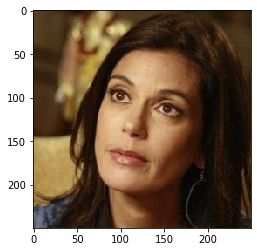

test image is :  Teri_Hatcher


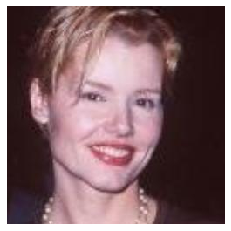

test image is :  Geena_Davis


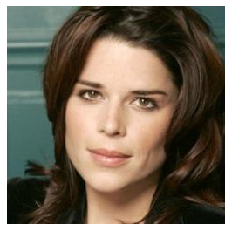

test image is :  Neve_Campbell


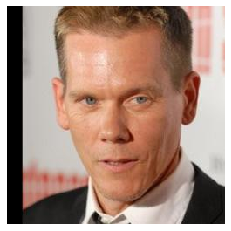

test image is :  Kevin_Bacon


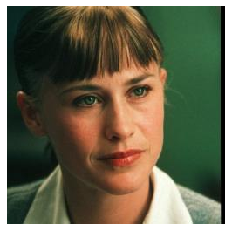

test image is :  Patricia_Arquette


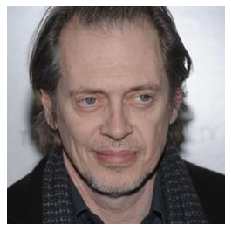

test image is :  Steve_Buscemi


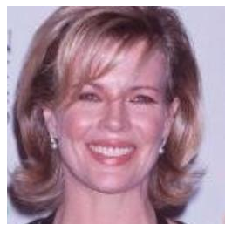

test image is :  Kim_Basinger


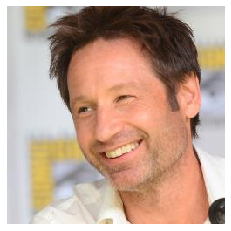

test image is :  David_Duchovny


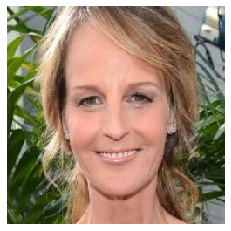

test image is :  Helen_Hunt


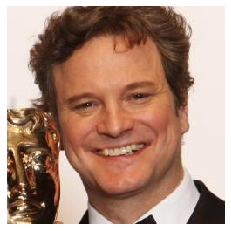

test image is :  Colin_Firth


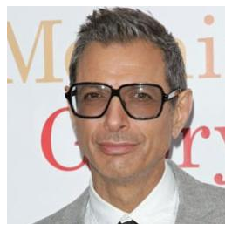

test image is :  Jeff_Goldblum


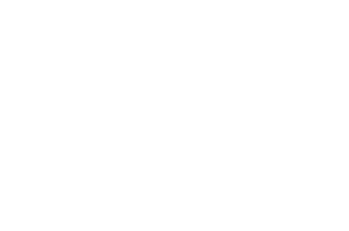

In [7]:
alpha_margin = 0.40

for celeb  in os.listdir(test_dir):
    if not celeb.startswith('.'):
        test_img_path = os.path.join(test_dir, celeb)
        if not test_img_path.startswith('.'):
            for test_img  in os.listdir(test_img_path):
                if not test_img.startswith('.'):
                    
                    test_face = extract_face(os.path.join(test_img_path, test_img))
                    test_embedding = find_embedding(facenet_model, test_face, required_size)
                    test_embedding = l2_normalizer.transform(np.expand_dims(test_embedding, axis=0))[0]
                    
                    test_identity = 'Not in database'
                    for celeb_i in embedding_dict.keys():
                        embed_i = embedding_dict[celeb_i]
                        dissimilarity = distance.cosine(test_embedding, embed_i)
                        if dissimilarity < alpha_margin and dissimilarity < temp_min_distance:
                            test_identity = celeb_i
                            temp_min_distance = dissimilarity
                    
                    img = cv2.imread(os.path.join(test_img_path, test_img))
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img_rgb)
                    plt.show()
                    plt.axis('off')
                    print('test image is : ', test_identity)


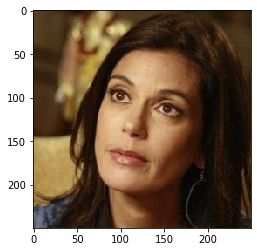

test image is :  Teri_Hatcher


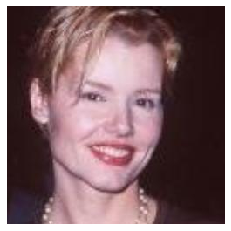

test image is :  Geena_Davis


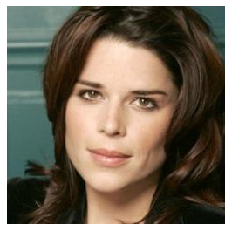

test image is :  Neve_Campbell


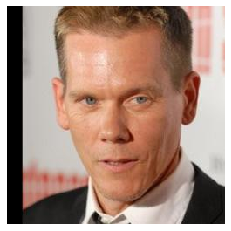

test image is :  Kevin_Bacon


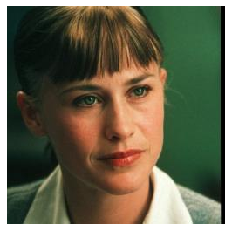

test image is :  Patricia_Arquette


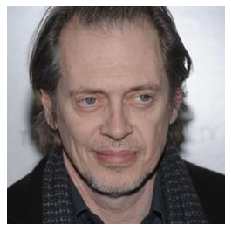

test image is :  Steve_Buscemi


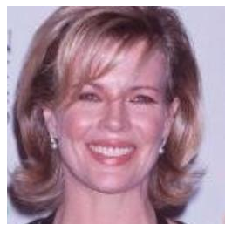

test image is :  Kim_Basinger


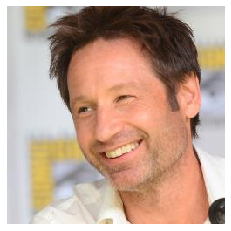

test image is :  David_Duchovny


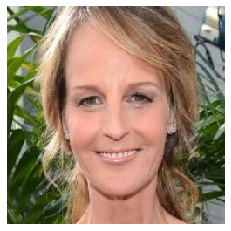

test image is :  Helen_Hunt


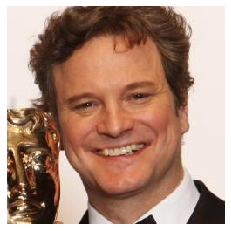

test image is :  Colin_Firth


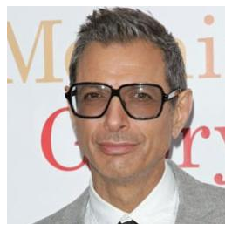

test image is :  Jeff_Goldblum


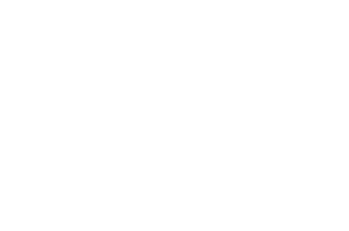

In [13]:
alpha_margin = 0.40

for celeb  in os.listdir(test_dir):
    if not celeb.startswith('.'):
        test_img_path = os.path.join(test_dir, celeb)
        if not test_img_path.startswith('.'):
            for test_img  in os.listdir(test_img_path):
                if not test_img.startswith('.'):
                    
                    test_face = extract_face(os.path.join(test_img_path, test_img))
                    test_embedding = find_embedding(facenet_model, test_face, required_size)
                    test_embedding = l2_normalizer.transform(np.expand_dims(test_embedding, axis=0))[0]
                    temp_min_distance = float("inf")
                    test_identity = 'Not in database'
                    for celeb_i in embedding_dict.keys():
                        embed_i = embedding_dict[celeb_i]
                        dissimilarity = distance.cosine(test_embedding, embed_i)
                        if dissimilarity < alpha_margin and dissimilarity < temp_min_distance:
                            test_identity = celeb_i
                            temp_min_distance = dissimilarity
                    
                    img = cv2.imread(os.path.join(test_img_path, test_img))
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img_rgb)
                    plt.show()
                    plt.axis('off')
                    print('test image is : ', test_identity)


#  Create a generalized function for Face Recignition using model of interest:

This function identified the given faces selected in an image, given the model of interest. Then I will use this function to identify every face in a image usng model of interest.

In [8]:
def classifyFace(model,size, face):
    face = cv2.resize(face, required_size)
    face = np.expand_dims(face, axis=0)
    pred = model.predict(face)
    test_identity = 'Not in database'
        
    if len(pred[0])!=128:
        test_dir = 'keras-facenet/data/test'
        listGroupsTest = os.listdir(test_dir) 
        listGroupsTest = [f for f in listGroupsTest if not f.startswith('.')]
        
        name = np.argmax(pred, axis=-1)
        test_identity = listGroupsTest[name[0]]
       
    else:
        for celeb_i in embedding_dict.keys():
            embed_i = embedding_dict[celeb_i]
            dissimilarity = distance.cosine(pred, embed_i)
            if dissimilarity < alpha_margin:
                test_identity = celeb_i

    return test_identity


# 4.	What if there are multiple faces in the images?!

IImage ‘test_3face.jpg’ includes 3 faces, 2 of which is in our database. in the following function I am performing a face recognition given a image with multiple faces in it. the prediction will be done through the model of interest, specified in the function arguments. since VGG16 and Resnet use (224,224) but FaceNet use (160,160), the required size should also be specified. this function also writes the resulting prediction on the image, and saves it with a string starting with your specified string, continued by the model name.

In [31]:
img_path = 'test_3face.jpg'
required_size = (224, 224)
def face_recognition_multipleFaces(model, img_path, required_size, result_name):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    result_faces = detector.detect_faces(img_rgb)
    for box in result_faces:

        face_i, xy1, xy2 = get_points(img_rgb, box['box'])
        face_i = normalize(face_i)
        prediction = classifyFace(model, required_size, face_i)
#         print(box, prediction)

        cv2.rectangle(img, xy1, xy2 ,(0,0, 255),3)
        cv2.putText(img,prediction, xy1,cv2.FONT_HERSHEY_PLAIN, 5, (0,0,255), 5)
    cv2.imwrite(str(result_name)+'.jpg',img)
    return img



# Comparison of models on images with multiple face:

Here I am showing the predicton of models created using transfer learning and finetuning on the convolutional base of VGG16 and Resnet50

# Using Developed Models:

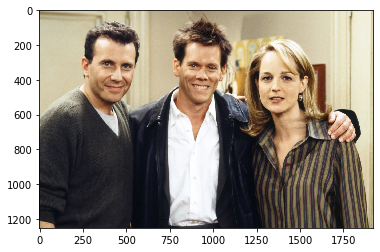

In [26]:
img_path = 'test_3face.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()



//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  vgg16_TL_1layer.h5


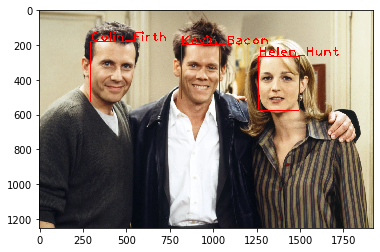

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  vgg16_TL.h5


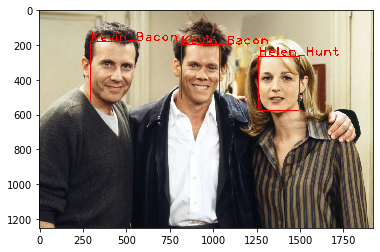

face recognition based on model:  vgg16_FT.h5


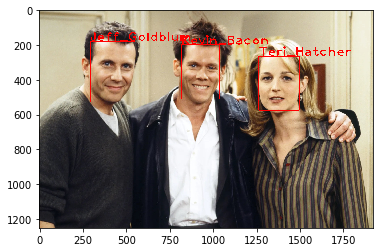

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  resnet50_TL_1layer.h5


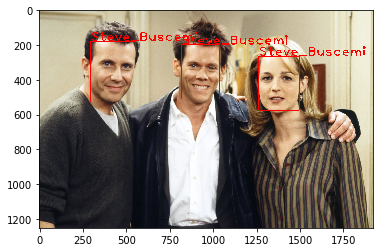

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  resnet50_TL2.h5


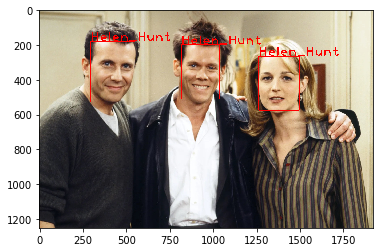

face recognition based on model:  resnet50_FT.h5


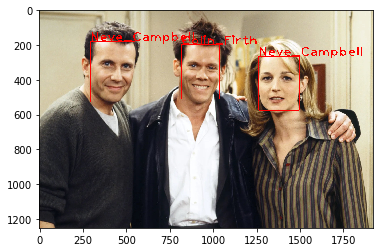

face recognition based on model:  vgg16_FT.h5


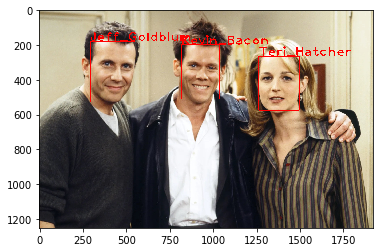

In [84]:
models= ['vgg16_TL_1layer.h5','vgg16_TL.h5','vgg16_FT.h5','resnet50_TL_1layer.h5',
         'resnet50_TL2.h5','resnet50_FT.h5' ,'vgg16_FT.h5']
required_size=(224,224)
for m in range(len(models)):
    modelname = models[m]
    model = load_model(modelname)
    required_size = (224, 224)
    print("face recognition based on model: ", modelname)
    FR_img = face_recognition_multipleFaces(model, img_path, required_size, 'result'+modelname+str(m))
    img_rgb = cv2.cvtColor(FR_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    
    

In [ ]:
# Using less clear images

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  vgg16_TL_1layer.h5


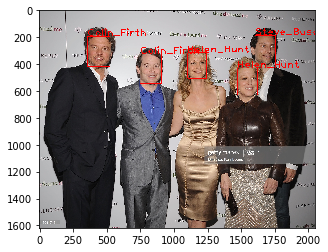

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  vgg16_TL.h5


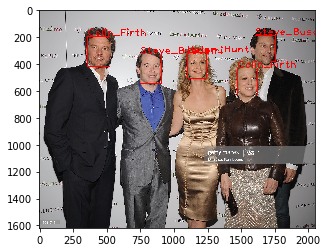

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  resnet50_TL_1layer.h5


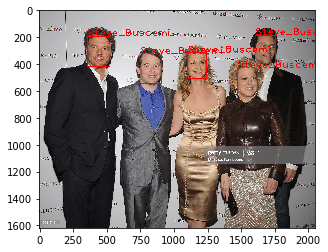

//anaconda3/envs/DLpy37/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


face recognition based on model:  resnet50_TL.h5


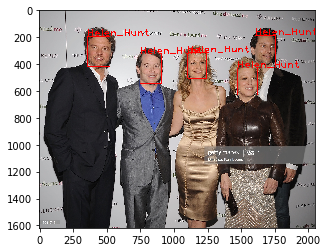

face recognition based on model:  resnet50_FT.h5


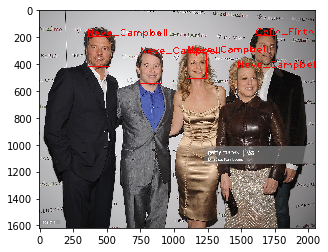

In [79]:
img_path = '3.jpg'
multi_face_imgs_path = 'multi_face_imgs'
# multi_face_imgs_dir = os.listdir(multi_face_imgs_path)
fullimagepath = os.path.join(multi_face_imgs_path, img_path)

models= ['vgg16_TL_1layer.h5','vgg16_TL.h5','resnet50_TL_1layer.h5','resnet50_TL.h5','resnet50_FT.h5' ]

for m in range(len(models)):
    modelname = models[m]
    model = load_model(modelname)
    required_size = (224, 224)
    print("face recognition based on model: ", modelname)
    FR_img = face_recognition_multipleFaces(model, fullimagepath, required_size, 'result'+modelname+str(m))
    img_rgb = cv2.cvtColor(FR_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    
    

# Using FaceNet Model:

face recognition based on model: FaceNet model
{'box': [817, 200, 221, 311], 'confidence': 0.9999356269836426, 'keypoints': {'left_eye': (891, 319), 'right_eye': (992, 333), 'nose': (940, 389), 'mouth_left': (876, 425), 'mouth_right': (979, 438)}} Kevin_Bacon
{'box': [296, 180, 255, 348], 'confidence': 0.9996943473815918, 'keypoints': {'left_eye': (394, 313), 'right_eye': (504, 321), 'nose': (460, 400), 'mouth_left': (379, 432), 'mouth_right': (491, 439)}} Not in database
{'box': [1263, 265, 233, 310], 'confidence': 0.9994908571243286, 'keypoints': {'left_eye': (1314, 392), 'right_eye': (1425, 391), 'nose': (1357, 451), 'mouth_left': (1320, 511), 'mouth_right': (1411, 511)}} Helen_Hunt


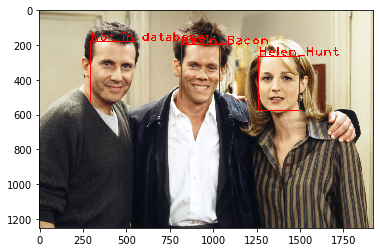

face recognition based on model: FaceNet model
{'box': [1603, 188, 149, 204], 'confidence': 0.9999979734420776, 'keypoints': {'left_eye': (1669, 266), 'right_eye': (1734, 273), 'nose': (1712, 312), 'mouth_left': (1663, 336), 'mouth_right': (1724, 343)}} Not in database
{'box': [358, 194, 169, 226], 'confidence': 0.9999855756759644, 'keypoints': {'left_eye': (412, 279), 'right_eye': (489, 288), 'nose': (446, 325), 'mouth_left': (406, 357), 'mouth_right': (477, 368)}} Colin_Firth
{'box': [750, 327, 158, 220], 'confidence': 0.9998832941055298, 'keypoints': {'left_eye': (800, 417), 'right_eye': (870, 415), 'nose': (844, 456), 'mouth_left': (805, 488), 'mouth_right': (872, 485)}} Not in database
{'box': [1472, 431, 149, 200], 'confidence': 0.9992914199829102, 'keypoints': {'left_eye': (1527, 509), 'right_eye': (1595, 507), 'nose': (1570, 548), 'mouth_left': (1526, 577), 'mouth_right': (1590, 576)}} Not in database
{'box': [1102, 317, 141, 189], 'confidence': 0.9990731477737427, 'keypoints':

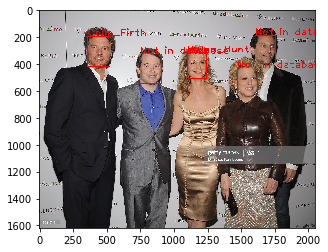

face recognition based on model: FaceNet model
{'box': [125, 107, 87, 114], 'confidence': 0.9999996423721313, 'keypoints': {'left_eye': (161, 148), 'right_eye': (201, 154), 'nose': (187, 170), 'mouth_left': (160, 191), 'mouth_right': (197, 195)}} Helen_Hunt
{'box': [406, 80, 103, 130], 'confidence': 0.9999984502792358, 'keypoints': {'left_eye': (438, 129), 'right_eye': (487, 130), 'nose': (461, 156), 'mouth_left': (439, 180), 'mouth_right': (481, 182)}} Colin_Firth


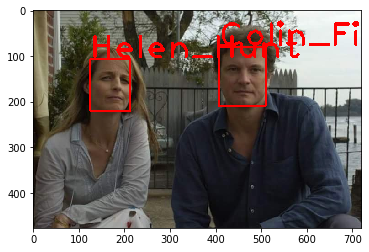

In [11]:
multi_face_imgs_path = 'multi_face_imgs'
multi_face_imgs_dir = os.listdir(multi_face_imgs_path)
for multi in multi_face_imgs_dir:
    if not multi.startswith('.'):
        fullimagepath = os.path.join(multi_face_imgs_path, multi)

        required_size = (160, 160)
        print("face recognition based on model: FaceNet model")
        FR_img = face_recognition_multipleFaces(facenet_model, fullimagepath, required_size, 'result'+modelname+str(m))
        img_rgb = cv2.cvtColor(FR_img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()


In [36]:
multi_face_imgs_dir
candidate_images

['Teri_Hatcher',
 'Geena_Davis',
 'Neve_Campbell',
 '.DS_Store',
 'Kevin_Bacon',
 'Patricia_Arquette',
 'Steve_Buscemi',
 'Kim_Basinger',
 'David_Duchovny',
 'Helen_Hunt',
 'Colin_Firth',
 'Jeff_Goldblum']